## 3.0 CNN Genre Classification

This notebook continues with supervised learning using the generated spectorgrams to do genre classification and prediction.

### Table of Contents
[3.1. Setup](#1.)<br>
[3.1.1 Loading libraries](#1.1)<br>
[3.1.2 Setting data directories](#1.2)<br>
[3.1.3 Defining functions](#1.3)<br>
[3.1.4 Reading in train, validation, and test data sets](#1.4)<br>

[3.2. Convolutional Neural Network](#2.)<br>
[2.3.1 CNN setup](#2.1)<br>
[2.3.2 2D CNN](#2.2)<br>
[2.3.3 1D CNN](#2.3)<br>

### 3.1. Setup <a class="anchor" id="1."></a>

#### 3.1.1 Loading libraries <a class="anchor" id="1.1"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

import timeit
import datetime

from sklearn import preprocessing

#### 3.1.2 Setting data directories <a class="anchor" id="1.2"></a>

In [2]:
ds_description = '5x10s'
# Set the directory for the spectrograms
data_dir = f'./data/spect_subsample_{ds_description}_np'
print("Directory of spectrograms: {}".format(data_dir))

Directory of spectrograms: ./data/spect_subsample_5x10s_np


In [13]:
genre_dict = {0 : 'Hip-Hop',
              1 : 'Pop',
              2 : 'Folk',
              3 : 'Experimental',
              4 : 'Rock',
              5 : 'International',
              6 : 'Electronic',
              7 : 'Instrumental'}

#### 3.1.3 Defining functions <a class="anchor" id="1.3"></a>

In [39]:
def load_data(data_dir, ds_description, str_X, str_Y):
    '''
    Loads the .npy data files generated previously from the pre-processing ipynb
    Note: .npy files need to be in the format: train_spect_{ds_description}_np.npy
    
    Inputs
    ------
    data_dir: directory of the .npy files
    ds_description: e.g. '5x10s'  5 subsamples of 10s length
    str_X: str name of the 'X' data, either: 'spect' or 'X'
    str_Y: str name of the 'Y' data, either: 'labels' or 'Y'
    
    Returns
    -------
    6 numpy arrays of:
        train_{str_X}, train_{str_Y}, val_{str_X}, val_{str_Y}, test_{str_X}, test_{str_Y}
    '''
    assert (str_X in ['spect','X']), "Assertion Error, str_X must be either 'spect' or 'X'."
    assert (str_Y in ['labels','Y']), "Assertion Error, str_Y must be either 'labels' or 'Y'."
    
    print("Loading .npy data files...")
    # Start timer
    start_time = timeit.default_timer()

    train_str_X = np.load(f'{data_dir}/train_{str_X}_{ds_description}_np.npy')
    val_str_X = np.load(f'{data_dir}/val_{str_X}_{ds_description}_np.npy')
    test_str_X = np.load(f'{data_dir}/test_{str_X}_{ds_description}_np.npy')

    train_str_Y = np.load(f'{data_dir}/train_{str_Y}_{ds_description}_np.npy')
    val_str_Y = np.load(f'{data_dir}/val_{str_Y}_{ds_description}_np.npy')
    test_str_Y = np.load(f'{data_dir}/test_{str_Y}_{ds_description}_np.npy')
    
    elapsed = str(datetime.timedelta(seconds = timeit.default_timer() - start_time))
    print("", end='\n')
    print("Total processing time (h:mm:ss): {}".format(elapsed[:-7]))
    print("\nLoaded .npy data files, verifying shape of saved data...")
    print(f"Shape of 'train_{str_X}':", train_str_X.shape)
    print(f"Shape of 'train_{str_Y}':", train_str_Y.shape)

    print(f"Shape of 'val_{str_X}':", val_str_X.shape)
    print(f"Shape of 'val_{str_Y}':", val_str_Y.shape)

    print(f"Shape of 'test_{str_X}':", test_str_X.shape)
    print(f"Shape of 'test_{str_Y}':", test_str_Y.shape)
    
    return train_str_X, train_str_Y, val_str_X, val_str_Y, test_str_X, test_str_Y


def mkdir_p(mypath):
    '''
    Creates a directory. equivalent to using mkdir -p on the command line
    '''
    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: 
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

#### 3.1.4 Reading in train, validation, and test data sets <a class="anchor" id="1.4"></a>

In [5]:
# Read in the spectrogram and labels data from the .npy files
train_X, train_Y, val_X, val_Y, test_X, test_Y = load_data(
    data_dir, ds_description, 'X', 'Y')

Loading .npy data files...

Total processing time (h:mm:ss): 0:00:40

Loaded .npy data files, verifying shape of saved data...
Shape of 'train_X': (31970, 431, 128)
Shape of 'train_Y': (31970, 8)
Shape of 'val_X': (4000, 431, 128)
Shape of 'val_Y': (4000, 8)
Shape of 'test_X': (4000, 431, 128)
Shape of 'test_Y': (4000, 8)


### 3.2. Convolutional Neural Network <a class="anchor" id="2."></a>

#### 3.2.1 CNN setup <a class="anchor" id="2.1"></a>

In [18]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, CuDNNLSTM, Dropout, Activation, CuDNNGRU
from keras.layers import Conv1D, Conv2D, concatenate, MaxPooling1D, MaxPooling2D, Flatten, Embedding, Lambda

from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers

from os.path import isfile

#### 3.2.2 2D CNN <a class="anchor" id="2.2"></a>

In [40]:
model_name = 'cnn2D_1'
model_dir = f'./models/{model_name}'
print("Directory of model parameters to be saved: {}".format(model_dir))

Directory of model parameters to be saved: ./models/cnn2D_1


In [41]:
# Define hyper-parameters
hp = {'batch_size' : 32,
      'num_classes' : len(genre_dict),
      'kernel_size' : (3,3),
      'filter_size' : 3,
      'strides' : 1,
      'activation' : 'relu',
      'pool_size' : (2,2),
      'epochs' : 30,
      'optimizer' : 'adam'
     }
num_classes = len(genre_dict)

In [43]:
# Adding additional dimension for Conv2D
train_X1 = np.expand_dims(train_X, axis = -1)
val_X1 = np.expand_dims(val_X, axis = -1)

# Building the model
model = Sequential()
model.add(Conv2D(filters=hp['filter_size'],
                 kernel_size=hp['kernel_size'], 
                 strides=hp['strides'],
                 activation=hp['activation'],
                 input_shape=train_X1.shape[1:]
                ))
model.add(MaxPooling2D(pool_size=hp['pool_size']))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# Complie the model
model.compile(
            loss='categorical_crossentropy',
            optimizer=hp['optimizer'],
            metrics=['accuracy']
            )

# Create the directory for model parameters to be saved
mkdir_p(model_dir)

checkpoint_callback = ModelCheckpoint(f'{model_dir}/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
reducelr_callback = ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
callbacks_list = [checkpoint_callback, reducelr_callback]

# Fit the model and get training history.
print('Training...')
history = model.fit(train_X1, train_Y, batch_size=hp['batch_size'], epochs=hp['epochs'],
                    validation_data=(val_X1, val_Y), verbose=1, callbacks=callbacks_list)

Training...
Train on 31970 samples, validate on 4000 samples
Epoch 1/30
31970/31970 [==============================] - 23s 712us/step - loss: 1.7991 - acc: 0.3328 - val_loss: 1.8718 - val_acc: 0.3310

Epoch 00001: val_acc improved from -inf to 0.33100, saving model to ./models/cnn2D_1/weights.best.h5
Epoch 2/30
31970/31970 [==============================] - 22s 701us/step - loss: 1.4952 - acc: 0.4718 - val_loss: 1.8865 - val_acc: 0.3523

Epoch 00002: val_acc improved from 0.33100 to 0.35225, saving model to ./models/cnn2D_1/weights.best.h5
Epoch 3/30
31970/31970 [==============================] - 22s 701us/step - loss: 1.3202 - acc: 0.5454 - val_loss: 1.9910 - val_acc: 0.3277

Epoch 00003: val_acc did not improve from 0.35225
Epoch 4/30
31970/31970 [==============================] - 22s 696us/step - loss: 1.1761 - acc: 0.6041 - val_loss: 2.0654 - val_acc: 0.3270

Epoch 00004: val_acc did not improve from 0.35225
Epoch 5/30
31970/31970 [==============================] - 22s 701us/step -

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


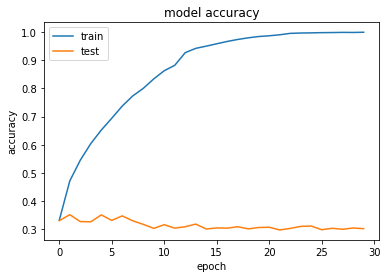

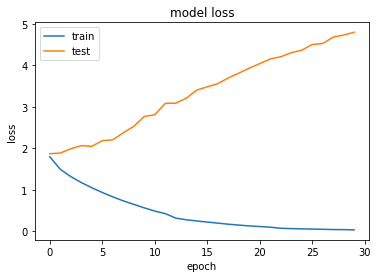

In [45]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
show_summary_stats(history)

#### 3.2.3 1D CNN <a class="anchor" id="2.3"></a>

In [83]:
model_name = 'cnn1D_16'
model_dir = f'./models/{model_name}'
print("Directory of model parameters to be saved: {}".format(model_dir))

# Define hyper-parameters
hp = {'batch_size' : 32,
      'kernel_size1' : 3,
      'kernel_size2' : 5,
      'filter_size1' : 64,
      'filter_size2' : 128,
      'strides' : 1,
      'activation' : 'relu',
      'pool_size1' : 2,
      'pool_size2' : 3,
      'l2' : 0.01,
      'epochs' : 30,
      'optimizer' : 'adam',
      'dense1' : 16,
      'dense2' : 32
     }
num_classes = len(genre_dict)

# Building the model
K.clear_session()
model = Sequential()
model.add(Conv1D(filters=hp['filter_size1'],
                 kernel_size=hp['kernel_size1'], 
                 strides=hp['strides'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2']),
                 input_shape=train_X.shape[1:]
                ))
model.add(MaxPooling1D(pool_size=hp['pool_size1']))

model.add(Conv1D(filters=hp['filter_size2'],
                 kernel_size=hp['kernel_size2'], 
                 strides=hp['strides'],
                 activation=hp['activation'],
                 kernel_regularizer=regularizers.l2(hp['l2'])
                ))
model.add(MaxPooling1D(pool_size=hp['pool_size2']))

model.add(Flatten())
model.add(Dense(hp['dense1'], activation='relu'))
model.add(Dense(hp['dense2'], activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Complie the model
model.compile(
            loss='categorical_crossentropy',
            optimizer=hp['optimizer'],
            metrics=['accuracy']
            )

# Print model summary
print(model.summary())

# Create the directory for model parameters to be saved
mkdir_p(model_dir)

checkpoint_callback = ModelCheckpoint(f'{model_dir}/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
reducelr_callback = ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
callbacks_list = [checkpoint_callback, reducelr_callback]

# Fit the model and get training history.
print('Training...')
history = model.fit(train_X, train_Y, batch_size=hp['batch_size'], epochs=hp['epochs'],
                    validation_data=(val_X, val_Y), verbose=1, callbacks=callbacks_list)
    

Directory of model parameters to be saved: ./models/cnn1D_16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 429, 64)           24640     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 214, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 210, 128)          41088     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 70, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8960)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                143376    
_________________________________________________________________
dense_2 (Dense)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


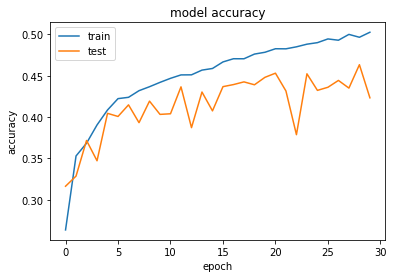

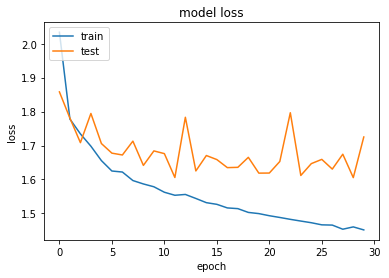

In [84]:
show_summary_stats(history)

#### To rerun with more epochs: cnn1D_15

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


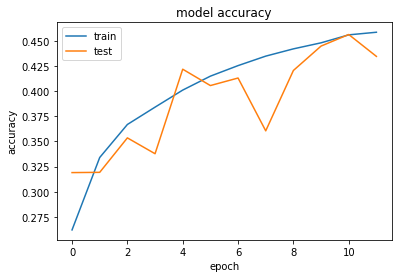

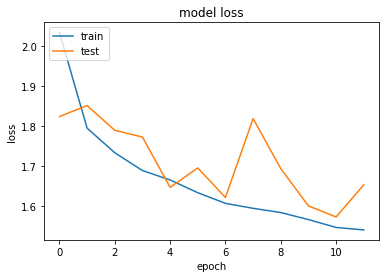

In [82]:
show_summary_stats(history)